In [142]:
%cd C:\Users\yukir\Documents\GitHub\Text_Mining\py

from nlp_processing import *
set_global_determinism(seed=1337)

%cd C:\Users\yukir\Documents\Monicas_workspace\Dental\LDA

C:\Users\yukir\Documents\GitHub\Text_Mining\py
C:\Users\yukir\Documents\Monicas_workspace\Dental\LDA


In [143]:
from gensim.models.ldamodel import LdaModel 
from gensim.models.callbacks import CoherenceMetric 
from gensim import corpora 
from gensim.models.callbacks import PerplexityMetric 
import logging 
import pickle 
import pyLDAvis

from gensim.models.coherencemodel import CoherenceModel 
import matplotlib.pyplot as plt

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from konlpy.tag import Mecab 
from konlpy.tag import Okt
okt = Okt()
from tqdm import tqdm 
import re 
import pickle 
import csv

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models
from gensim.models import CoherenceModel
import gensim
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [144]:
def clean_text(text): 
    """ 한글, 영문, 숫자만 남기고 제거한다. 
    :param text: 
    :return: 
    """ 
    text = text.replace(".", " ").strip() 
    text = text.replace("·", " ").strip() 
    pattern = '[^ ㄱ-ㅣ가-힣|0-9|a-zA-Z]+' 
    text = re.sub(pattern=pattern, repl='', string=text) 
    return text 
    
def get_nouns(tokenizer, sentence): 
    """ 단어의 길이가 2이상인 일반명사(NNG),
     고유명사(NNP), 외국어(SL)만을 반환한다. 
     :param tokenizer: 
     :param sentence: :return: """ 
    tagged = tokenizer.nouns(sentence)
    nouns = [s for s in tagged if len(s)>1] 
     
    return nouns 
     
     
def tokenize(df): 
    tokenizer = okt
    processed_data = [] 
    for sent in tqdm(df['cleaned_reviews']):
        sentence = clean_text(sent.replace('\n', '').strip()) 
        processed_data.append(get_nouns(tokenizer, sentence)) 
        
    return processed_data
    
    
def save_processed_data(processed_data): 
    """ 토큰 분리한 데이터를 csv로 저장 :param processed_data: :return: """ 
    
    with open('lsa_token_pos.csv', 'w', newline='', encoding='utf-8') as f: 
        writer = csv.writer(f) 
        for data in processed_data:
             writer.writerow(data)

In [145]:
dental_pos = pd.read_csv('dental_pos.csv', index_col=0)
df = dental_pos.copy()

{'whiskers': [<matplotlib.lines.Line2D at 0x12fb20f8ee0>,
 'caps': [<matplotlib.lines.Line2D at 0x1303fe50160>,
 'boxes': [<matplotlib.lines.Line2D at 0x12fb20f85e0>],
 'medians': [<matplotlib.lines.Line2D at 0x12f98246700>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f98246f40>],
 'means': []}

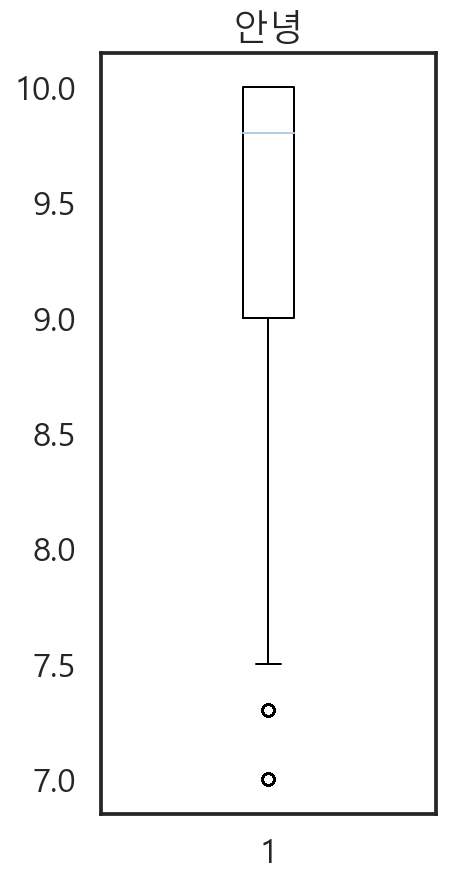

In [146]:
plt.figure(figsize = (3,7))
plt.rc('font', family='Malgun Gothic') 
%config InlineBackend.figure_format = 'retina'
plt.title("안녕")
plt.boxplot(df['stars'])

## **TOKENIZING**

In [147]:
print(len(df))
df = df.dropna()
print(len(df))
df = df.drop_duplicates('cleaned_reviews')
print(len(df))

130663
129837
37934


In [148]:
for sent in tqdm(df['cleaned_reviews']):
    try:
        sentence = clean_text(sent.replace('\n', '').strip())
        # print(sentence)
    except:
        print(sent)
        pass

100%|██████████| 37934/37934 [00:00<00:00, 203947.16it/s]


In [149]:
## 오래걸리니까 조심

if __name__ == '__main__':
     # df = pd.read_csv('negative.csv', index_col = 0)
     processed_data = tokenize(df) # description 부분을 토크나이징 한다. 
     
     # 토큰 분리한 데이터를 저장 
     save_processed_data(processed_data)


100%|██████████| 37934/37934 [15:11<00:00, 41.61it/s]


## **TF-IDF**

In [151]:
detokenized_doc = []
for i in range(len(processed_data)):
    t = ' '.join(processed_data[i])
    detokenized_doc.append(t)

df['detokenized_doc'] = detokenized_doc # 다시 text['headline_text']에 재저장

df['detokenized_doc'][:5]

0        사랑니 발치 가장 치과 역시 시간 정말 순식간 다른 통증 사랑니 무조건 여기 추천
1    매복 사랑니 발치 발치 이후 꼬매러 가야 발치 다음 소독 발치 이상 대기 소독 진행...
2    사랑니 발치 추천 지인 한번 사랑니 발치 때문 병원 군데 여기 제일 가격 바가지 처...
3    사랑니 여기 가라 강력 추천 사랑니 발치 처음 사람 가득 위층 사랑니 발치 정말 반...
4    사랑니 발치 실밥 제거 위해 방문 시간 일찍 사람 금방 진료 실밥 제거 통증 전혀 ...
Name: detokenized_doc, dtype: object

In [157]:
from nltk.corpus import stopwords  
stopwords.words('korean')[:10] 

stopwords_kor = stopwords.words('korean')

In [158]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=stopwords_kor,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[가-힣0-9]{1,}',  # num chars > 3
                             max_features=2000,             # max number of uniq words
                            ) 
data_vectorized = vectorizer.fit_transform(df['detokenized_doc'])
data_vectorized.shape # TF-IDF 행렬의 크기 확인

(37934, 2000)

In [159]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.7901842674118205 %


In [160]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=7,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=1337,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_top=lda_model.fit_transform(data_vectorized)

print(lda_model.components_)
print(lda_model.components_.shape) 

[[1.43048019e-01 5.14316395e+01 1.00404199e+02 ... 1.15366744e+01
  1.43170286e-01 5.86869952e+00]
 [1.43218542e-01 1.44103571e+02 3.98759026e+02 ... 1.43329743e-01
  1.43293443e-01 1.43121881e-01]
 [1.42904297e-01 1.43188606e-01 1.43309662e-01 ... 1.42924105e-01
  1.42971949e-01 1.43079100e-01]
 ...
 [1.43678344e-01 3.47317319e+01 1.43716437e+02 ... 1.42972612e-01
  6.90300858e+00 1.43155321e-01]
 [9.46174536e+00 1.43277938e-01 1.43221095e-01 ... 1.43435334e-01
  1.43089951e-01 1.42898639e-01]
 [1.42926883e-01 1.34209436e+01 1.21145231e+01 ... 1.42998301e-01
  1.43309067e-01 1.43052263e-01]]
(7, 2000)


In [161]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -958052.1346172474
Perplexity:  1327.911383317827
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 7, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 1337, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [162]:
# Define Search Param
search_params = {'n_components': [5,6, 7], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 6, 7]})

In [163]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -196673.8205845745
Model Perplexity:  1028.1829930974966


## **OUTPUT**

In [172]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df['cleaned_reviews'].tolist()))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.050000,0.050000,0.050000,0.800000,0.050000,3
Doc1,0.060000,0.060000,0.060000,0.770000,0.060000,3
Doc2,0.050000,0.050000,0.370000,0.470000,0.050000,3
Doc3,0.040000,0.040000,0.040000,0.830000,0.040000,3
Doc4,0.040000,0.080000,0.040000,0.790000,0.050000,3
Doc5,0.060000,0.060000,0.060000,0.760000,0.060000,3
Doc6,0.040000,0.040000,0.040000,0.830000,0.040000,3
Doc7,0.040000,0.040000,0.040000,0.830000,0.040000,3
Doc8,0.470000,0.060000,0.050000,0.360000,0.050000,0
Doc9,0.050000,0.040000,0.050000,0.820000,0.050000,3


In [173]:
terms = vectorizer.get_feature_names() # 단어 집합. 1,000개의 단어가 저장됨.

def get_topics(components, feature_names, n=10):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(lda_model.components_,terms)

Topic 1: [('스케일링', 855.46), ('진료', 711.4), ('치료', 636.63), ('방문', 538.06), ('치과', 508.5), ('병원', 490.78), ('선생님', 471.73), ('의사', 432.61), ('검진', 428.81), ('충치', 426.79)]
Topic 2: [('치료', 1217.04), ('치과', 1168.39), ('진료', 1008.78), ('선생님', 704.34), ('병원', 621.42), ('과잉', 571.18), ('설명', 554.74), ('원장', 542.55), ('의사', 535.63), ('예약', 521.79)]
Topic 3: [('접근성', 116.41), ('찾기', 100.53), ('위치', 96.92), ('교통', 70.04), ('치통', 65.71), ('임신', 61.13), ('실내', 58.12), ('사후관리', 56.07), ('한편', 55.41), ('조심', 50.52)]
Topic 4: [('치료', 967.68), ('스케일링', 964.87), ('진료', 923.24), ('설명', 777.82), ('선생님', 633.31), ('방문', 611.35), ('치과', 597.69), ('예약', 564.35), ('병원', 563.57), ('의사', 544.87)]
Topic 5: [('교정', 943.54), ('치료', 464.33), ('치과', 326.9), ('치아', 325.51), ('상담', 279.51), ('임플란트', 269.04), ('진료', 266.79), ('병원', 261.96), ('설명', 256.36), ('방문', 238.88)]
Topic 6: [('어린이', 154.18), ('주차', 142.69), ('주차장', 142.17), ('턱관절', 121.48), ('가요', 94.61), ('상가', 74.16), ('물리치료', 56.94), ('아파트', 49.16), ('요구',

In [174]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\yukir\anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \
C:\Users\yukir\anaconda3\envs\NLP\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  25.439494
1       51.163364 -159.968018       2        1  23.075694
4      -73.144554   21.523815       3        1  18.156097
0      -66.410133 -110.606438       4        1  17.781217
3       54.417324   12.443444       5        1  15.547499, topic_info=     Term         Freq        Total Category  logprob  loglift
813   사랑니  1510.000000  1510.000000  Default  30.0000  30.0000
655    발치  1186.000000  1186.000000  Default  29.0000  29.0000
191    교정  1373.000000  1373.000000  Default  28.0000  28.0000
519    마취   627.000000   627.000000  Default  27.0000  27.0000
546    매복   280.000000   280.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
1706   처음   124.108187   583.379016   Topic5  -5.1174   0.3136
1648   직원   156.108383  1297.261725   Topic5  -4.8880  -0.2562
1258   원장   150.374949  1346.286528   Topic5  -4.9254  -0.3307
1759   충치   112.997701  1456.843591   Topic5  -5.2111  -0.6954
37    간호사   111.342341  1047.120815   Topic5  -5.2259  -0.3799

[406 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2         1  0.361877   가격
2         2  0.182137   가격
2         3  0.218085   가격
2         4  0.166559   가격
2         5  0.070698   가격
...     ...       ...  ...
1981      3  0.092626   회사
1981      4  0.029250   회사
1981      5  0.107251   회사
1989      5  0.938057   후속
1997      1  0.963426   흔적

[777 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

In [175]:
df_document_topic.to_csv('LDA_tfidf_pos.csv')

In [176]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,10436
1,1,9943
2,0,6287
3,4,6232
4,3,5036


In [178]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,가가,가게,가격,가구,가글,가까이,가나,가능,가능성,가도,가득,가라,가량,가로,가방,가보,가성,가세,가스,가시,가야,가요,가운데,가입,가장,가족,가치,각오,간격,간곳,간김,간다,간단,간정,간지,간판,간호,간호사,간호원,간호조무사,간혹,갈고,갈수,감각,감당,감동,감사,감수,감안,감염,...,현실,현재,협소,협소하,협소해,형식,형태,혜택,호선,호전,호텔,혼란,홈페이지,홈플러스,홍대,홍보,화가,화로,화면,화목,화요일,화이트,화장실,확률,확신,확인,확장,환경,환자,활용,회복,회사,회전,횟수,효과,효율,후기,후다닥,후반,후속,후유증,후의,후회,휴가,휴대폰,휴무,휴일,흔적,희망,흰색
Topic0,1.526183,36.721297,134.805442,0.202362,12.365484,7.748237,8.292904,7.157082,2.006924,71.641408,1.814233,0.897285,0.472787,0.895540,8.845189,1.639423,3.619459,21.336877,0.200086,31.637131,29.168368,10.041750,5.296205,0.221019,42.365797,22.233400,9.967703,4.558364,5.608325,0.201700,0.200552,14.020247,1.862214,10.059168,0.613650,2.754760,21.239505,165.808615,8.931389,8.730895,6.440406,0.200934,4.803581,0.201307,0.203366,20.546960,8.697633,17.898988,13.245015,6.351577,...,0.200451,26.251415,10.257786,1.145292,0.200660,2.117567,1.595309,4.132216,0.200780,30.602063,4.596252,0.204319,0.201528,0.201074,10.948019,0.411670,1.284384,0.787539,1.157487,0.204338,0.221336,0.201544,68.692940,0.750510,0.202462,42.282255,2.574476,37.697439,248.683366,1.732466,3.065850,5.484057,0.881900,0.200182,35.319011,10.071024,13.194199,6.019318,0.200542,0.200800,0.201209,0.208304,0.210835,0.202257,0.229097,0.203220,2.410454,0.202428,2.963673,0.202166
Topic1,0.204787,55.227921,157.593000,0.200508,10.194886,13.446533,0.202510,18.041747,1.343640,35.237535,3.351682,3.538105,3.158904,0.633224,0.200062,1.010848,13.725749,15.034342,14.400900,10.794110,32.753318,44.890109,1.327733,0.206161,50.438998,135.338341,2.241212,2.404265,4.214164,0.202504,12.085146,16.693926,0.213245,0.202537,0.203494,3.903729,20.333542,419.371458,0.200710,0.207623,0.678098,0.200510,8.189948,0.200542,0.200510,14.209011,22.611463,0.201030,5.976718,0.200419,...,0.200376,28.481936,0.205728,7.756451,7.573130,3.653480,0.204655,11.297397,14.768818,0.200616,9.468998,0.200252,2.211732,11.089002,1.157943,0.703117,3.413414,4.005412,5.979870,3.419985,1.228410,4.224637,21.317789,0.202606,1.706068,75.583470,9.104588,29.360438,124.469109,0.202015,0.201860,29.301942,2.950367,1.708566,14.791274,2.337039,26.173561,0.202526,0.201475,0.201581,0.200153,0.202412,0.784069,0.201889,0.242419,0.203900,0.323225,0.202068,1.262885,6.771134
Topic2,0.205501,103.255008,322.603452,0.200547,3.633073,24.750898,1.940058,4.726767,20.297074,25.864773,0.203241,6.503814,8.166577,3.482585,0.201410,2.208667,0.204808,9.283916,0.200559,9.158047,46.313241,7.986595,0.217741,6.977258,69.111570,37.128882,3.942862,3.478515,4.198053,19.126728,31.650328,4.453955,2.451635,0.201325,14.807354,8.224036,0.213945,241.163008,0.200382,3.572678,4.592311,6.464868,19.766551,0.213228,0.203956,25.077047,9.577201,0.289203,5.088381,0.201029,...,0.201931,76.433709,4.727642,0.208434,0.200059,0.767184,2.853428,0.203524,0.201490,0.219813,0.202694,7.156961,1.573008,0.200947,0.267775,0.257236,0.520520,0.202366,13.226236,2.175942,8.158041,0.208153,0.606525,6.110144,0.416960,151.133197,0.200982,9.250448,133.102523,1.439319,0.201460,139.216857,0.202327,7.061413,8.422681,0.202191,58.353800,1.134287,1.576259,0.203502,0.201775,0.202291,0.630329,0.203751,2.414426,3.697035,6.741653,11.218555,0.290380,0.207566
Topic3,0.200084,30.595778,58.372979,0.200171,59.800781,17.373633,2.216756,7.306375,3.715801,9.766909,4.051548,45.228461,10.085997,0.730803,0.201525,10.729426,0.203231,14.674211,0.200465,10.480436,36.952034,3.614313,1.310337,1.085059,23.427171,5.765317,0.208399,3.135967,4.957225,0.204585,3.204953,4.740903,0.201640,0.586496,0.690842,0.202792,6.507415,110.500251,0.200651,13.110621,2.062450,1.853274,1.113828,8.051269,0.201190,15.931044,10.030544,2.904974,0.450997,3.571306,...,0.200527,11.021441,0.205632,0.200258,0.200331,1.940561,2.515966,1.441665,0.201312,0.917486,0.201679,0.202151,1.046027,0.387022,1.166226,0.205428,0.203371,3.384254,0.203164,0.201453,0.223169,0.205549,0.202630,0.201812,0.778077,76.992807,0.201306,4.263691,48.213923,1.086302,21.727525,21.915237,5.170593,0.207515,4.329431,1.306979,47.855446,2.469199,0.292494,10.843276,15.85

In [179]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,진료,치료,치과,설명,예약,병원,선생님,의사,환자,방문,직원,원장,대기,스케일링,과잉
Topic 1,스케일링,진료,치과,선생님,치료,병원,방문,의사,검진,설명,예약,직원,과잉,간호사,원장
Topic 2,치료,진료,충치,치과,스케일링,설명,방문,치아,과잉,병원,선생님,의사,신경치료,예약,레진
Topic 3,사랑니,발치,마취,스케일링,매복,방문,치과,병원,잇몸,치료,선생님,설명,예약,진료,의사
Topic 4,교정,치과,치료,상담,선생님,원장,임플란트,진료,병원,설명,의사,추천,치아,유지,정말


In [180]:
len(df)

37934

In [182]:
a = df_document_topic.dominant_topic.tolist()

In [183]:
df['dominant_topic'] =a
df.head()

,hospital,reviews,stars,address,add_clean,cleaned_reviews,detokenized_doc,dominant_topic
0,잎사귀치과병원,사랑니 발치로 가장 유명한 치과라 들었는데 역시는 역시였습니다! 기다리는 시간은 고...,8.3,서울 서대문구 신촌동,서울,사랑니 발치로 가장 유명한 치과라 들었는데 역시는 역시였습니다 기다리는 시간은 고통...,사랑니 발치 가장 치과 역시 시간 정말 순식간 다른 통증 사랑니 무조건 여기 추천,3
1,잎사귀치과병원,"매복 사랑니 발치는 발치 이후에 꼬매러 가야하는데, 저는 발치하고 다음 날 소독만 ...",8.8,서울 서대문구 신촌동,서울,매복 사랑니 발치는 발치 이후에 꼬매러 가야하는데 저는 발치하고 다음 날 소독만 하...,매복 사랑니 발치 발치 이후 꼬매러 가야 발치 다음 소독 발치 이상 대기 소독 진행...,3
2,잎사귀치과병원,사랑니 발치를 잘한다고 추천받은 곳이라 지인 믿고 한번 가봤습니다 !제가 사랑니 발...,8.8,서울 서대문구 신촌동,서울,사랑니 발치를 잘한다고 추천받은 곳이라 지인 믿고 한번 가봤습니다 제가 사랑니 발치...,사랑니 발치 추천 지인 한번 사랑니 발치 때문 병원 군데 여기 제일 가격 바가지 처...,3
3,잎사귀치과병원,사랑니 뽑을 거면 여기로 가라고 강력 추천을 받아서 오게 되었습니다. 사랑니 발치는...,10.0,서울 서대문구 신촌동,서울,사랑니 뽑을 거면 여기로 가라고 강력 추천을 받아서 오게 되었습니다 사랑니 발치는...,사랑니 여기 가라 강력 추천 사랑니 발치 처음 사람 가득 위층 사랑니 발치 정말 반...,3
4,잎사귀치과병원,사랑니 발치 후 실밥 제거하기 위해 방문하였습니다. 예약시간보다 일찍 갔더니 사람도...,9.8,서울 서대문구 신촌동,서울,사랑니 발치 후 실밥 제거하기 위해 방문하였습니다 예약시간보다 일찍 갔더니 사람도...,사랑니 발치 실밥 제거 위해 방문 시간 일찍 사람 금방 진료 실밥 제거 통증 전혀 ...,3


In [184]:
df.to_csv('final_dental_pos.csv')

In [238]:
more = df[df['stars']==10]

for i in more[more['dominant_topic']==1]['cleaned_reviews']:
    # print('-', i)
    if '소독'in i:
        print('-', i)

- 사랑니 발치를 위해 방문했습니다  시설도 깨끗하고 직원분들이 매우 친절하십니다  무엇보다 사후 관리가 아주 꼼꼼합니다  발치 후 통증 확인차 전화를 주시고 소독하러 내원하라고 하기도 합니다  귀찮은 것을 싫어하시면 호불호가 갈릴 수도 있겠지만 후관리는 잘 해 주시는 듯 합니다  의사 선생님 실력도 좋으십니다  쑥 뽑으세요   아픈 줄도 모르게    굳이 단점을 꼽자면 가격이 동네 치과보다는 비싼 편이고 여러 가지 부가적 진료를 권유하십니다
-  진료는 빠르고 안전하게 안아프게 해주셔서 좋았습니다시설은 깨끗하게 정리되어 있었으며 진료는 예약시간보다 일찍 왔는데도 빠르게 진료 볼수있게 해주셨고 치아검진도 해주셔서 좋았습니다 진료는 빠르고 안아프게 해주셨고 너무 멀어서 소독하러 오기 어렵다고 하니깐 주사놔주시고 안내도 친절하게 해주셔서 좋았습니다 병원시설은 깨끗하고 기다리는 것도 예약한 시간보다 빨리왔는데 빠르게 진료받을 수 있게 해주시고 안내하시는 분도 윗층 아래층 같이 동행해주시고 친절해서 좋았습니다
- 오목교역 1번 출구에서 1분거리에 위치하여 근접성이 좋습니다  교정에서 가장 중요한 부분은 교정 후 관리라고 생각하는데요 매년 정기검진을 문자로 안내해주어 잊지않고 검진할 수 있습니다  교정 담당 원장님도 친절하시고 궁금한 점에 대해 잘 알려주세요  그리고 꼼꼼하게 진료해주십니다  또한 치위생사선생님들도 모두 친절하시고 스케일링을 잘해주십니다  다른 사람들은 스케일링 받다가 피가 나거나 한다는데 저는 그런 적이 전혀 없었어요  스케일링 후 소독도 해주시기에 쾌적하게 집에 갈 수 있습니다  진료실도 다 오픈형이고 전체적으로 흰색 톤에 밝고 청결한 분위기에요  실제로도 깨끗합니다  예약하면 예약시간에 거의 맞춰서 바로 안내받을 수 있습니다 
-  무섭지 않은 치과스케일링 전에 의사선생님께서 전체적으로 구강검사도 자세하고 꼼꼼하게 봐주시고 관리법과 치실 사용법도 잘 알려주셨습니다  스케일링 해주신 위생사님도 좋았어요 시설은 깨끗하고 코로나 시국에 맞게 소독과 출입